## Data Splitting Notebook

We have three available datasets:
1. 20 images annotated together by our 2 annotators
2. 20 images with duplicated annotations
3. 60 images with single annotations produced by one of our annotators (50% each)

We aim to split the aforementioned data as follows:

- **Tets split:** 5 images from 1. and 10 images from 2.
- **Validation split:** 5 images from 1. and 10 images from 3 (5 for each annotator)
- **Train split:** 10 images form 1., 10 images from 2. with randomly sampled annotations, 50 images form 3.

|  | Dataset 1 | Dataset 2 | Dataset 3 |
| --- | --- | --- | --- |
| Test | 5 | 10 | - |
| Validation | 5 | - | 10 (5 for each ann.) |
| Train | 10 | 10 | 50 |

In [14]:
import os
import sys
import shutil
sys.path.append(os.path.dirname(os.getcwd()))

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt

from src.model.dataset import MaskRCNNDataset
from src.utils.utils import *
from src.utils.const import *


In [15]:
# annotated dataset
dataset_1 = "../dataset/merge_together_corrected_m"
dataset_2_LT = "../dataset/merge_alone_1_corrected_LT_m"
dataset_2_EK = "../dataset/merge_alone_1_corrected_EK_m"
dataset_3 = "../dataset/merge_alone_2_corrected_LT_m"
dataset_4 = "../dataset/merge_alone_3_corrected_EK_m"

images_paths_train = []
images_paths_val = []
images_paths_test = []

random_seed = 1234
np.random.seed(random_seed)

In [16]:
def create_dataset(images_paths, dataset_path):
    if os.path.exists(dataset_path):
        shutil.rmtree(dataset_path)
    os.makedirs(os.path.join(dataset_path, IMAGES_SUBFOLDER), exist_ok=True)
    os.makedirs(os.path.join(dataset_path, ANNOTATIONS_SUBFOLDER), exist_ok=True)
    for image_path in images_paths:
        # get the target path for the image
        old_dataset_path = os.path.join(*image_path.split(os.sep)[:-4])
        target_path = get_annotations_paths([image_path], old_dataset_path)[0]
        # copy the image and the annotation to the dataset folder
        image_rel_path = os.path.join(*image_path.split(os.sep)[-3:])
        target_rel_path = os.path.join(*target_path.split(os.sep)[-3:])
        os.makedirs(os.path.join(dataset_path, IMAGES_SUBFOLDER, os.path.dirname(image_rel_path)), exist_ok=True)
        os.makedirs(os.path.join(dataset_path, ANNOTATIONS_SUBFOLDER, os.path.dirname(target_rel_path)), exist_ok=True)
        shutil.copyfile(image_path, os.path.join(dataset_path, IMAGES_SUBFOLDER ,image_rel_path))
        shutil.copyfile(target_path, os.path.join(dataset_path, ANNOTATIONS_SUBFOLDER, target_rel_path))

def bin(data: List, n_bins: int):
    """
    Bin the data into n_bins bins of similar size
    :param data: data to be binned
    :param n_bins: number of bins
    :return: binned data
    """
    data = np.array(data)
    # sort the data
    sorted_indices = data.argsort()
    bins = np.linspace(0, len(data), n_bins + 1)
    binned_data = np.digitize(sorted_indices, bins) - 1
    return binned_data

    

## Dataset 1

We split it into three subsets of size 25%, 25% and 50%.

Number of images in dataset 1: 20


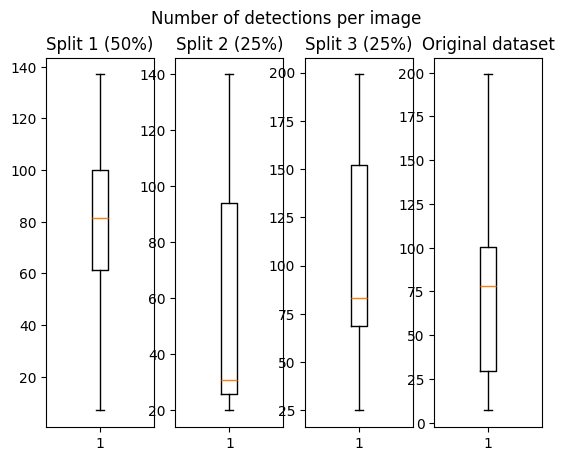

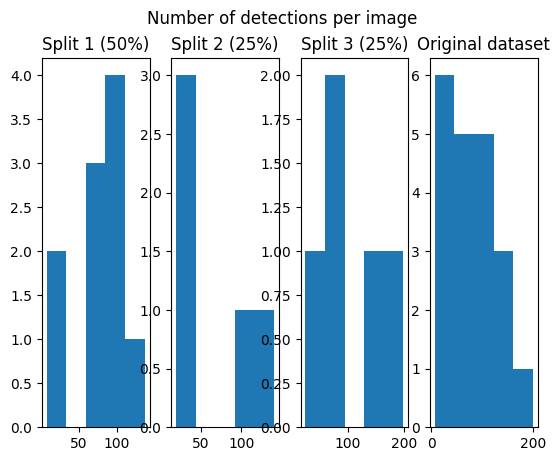

In [17]:
image_paths_1 = get_images_paths(dataset_1)
print(f"Number of images in dataset 1: {len(image_paths_1)}")
target_paths_1 = get_annotations_paths(image_paths_1, dataset_1)
nr_detections_1 = []
for target_path in target_paths_1:
    target = pd.read_csv(target_path)
    nr_detections_1.append(len(target))
bins_1 = bin(nr_detections_1, 5)



x_1, x_temp, y_1, y_temp = train_test_split(image_paths_1, nr_detections_1, test_size=0.5, stratify=bins_1)
# create the dataset for the first split
bins_temp = bin(y_temp, 5)
x_2, x_3, y_2, y_3 = train_test_split(x_temp, y_temp, test_size=0.5, stratify=bins_temp)



images_paths_train.extend(x_1)
images_paths_val.extend(x_2)
images_paths_test.extend(x_3)

figure, ax = plt.subplots(1, 4)
ax[0].boxplot(y_1)
ax[0].set_title("Split 1 (50%)")
ax[1].boxplot(y_2)
ax[1].set_title("Split 2 (25%)")
ax[2].boxplot(y_3)
ax[2].set_title("Split 3 (25%)")
ax[3].boxplot(nr_detections_1)
ax[3].set_title("Original dataset")
figure.suptitle("Number of detections per image")
plt.show()

figure, ax = plt.subplots(1, 4)
ax[0].hist(y_1, bins=5)
ax[0].set_title("Split 1 (50%)")
ax[1].hist(y_2, bins=5)
ax[1].set_title("Split 2 (25%)")
ax[2].hist(y_3, bins=5)
ax[2].set_title("Split 3 (25%)")
ax[3].hist(nr_detections_1, bins=5)
ax[3].set_title("Original dataset")
figure.suptitle("Number of detections per image")
plt.show()



## Dataset 2

Here we first need to merge the two annotations into a sigle one, by adding an additional columnrepresentig the annotator corresponding to the detection. Next we split it in 50% and 50% respectively for training and testing. Having this info at test time is essential to compare the model performances vs one annotator an the annotators one vs the oter, to asses if the model was able to lean up tp the noise in the labels.

[0, 32, 27, 17, 25, 15, 5, 29, 21, 3, 8, 25, 56, 38, 89, 26, 28, 20, 22, 19]


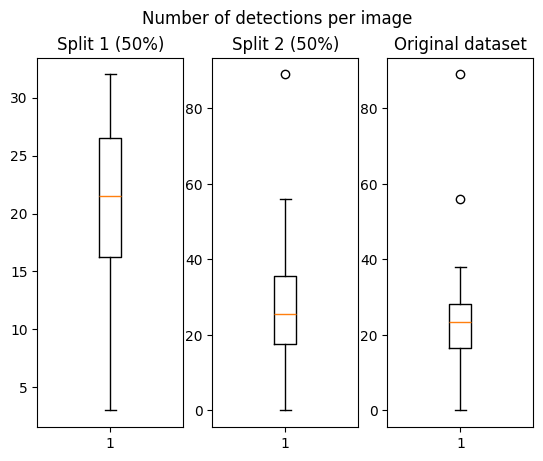

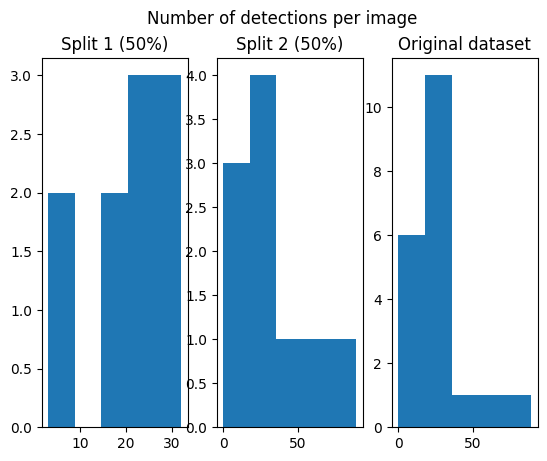

In [18]:
# merge the two datasets
image_paths_1 = get_images_paths(dataset_2_LT)
target_paths_1 = get_annotations_paths(image_paths_1, dataset_2_LT)
image_paths_2 = get_images_paths(dataset_2_EK)
target_paths_2 = get_annotations_paths(image_paths_2, dataset_2_EK)
images_paths_new = []

new_dataset = "../dataset/merge_alone_1_corrected_m"
os.makedirs(os.path.join(new_dataset, IMAGES_SUBFOLDER), exist_ok=True)
os.makedirs(os.path.join(new_dataset, ANNOTATIONS_SUBFOLDER), exist_ok=True)

for image_path_1, image_path_2, target_path_1, target_path_2 in zip(image_paths_1, image_paths_2 ,target_paths_1, target_paths_2):
    image_rel_path = os.path.join(*image_path_1.split(os.sep)[-3:])
    image_rel_path_2 = os.path.join(*image_path_2.split(os.sep)[-3:])
    assert image_rel_path == image_rel_path_2, "The images do not correspond"
    target_rel_path = os.path.join(*target_path_1.split(os.sep)[-3:])
    df_1 = pd.read_csv(target_path_1)
    df_1["annotator"] = 1
    df_2 = pd.read_csv(target_path_2)
    df_2["annotator"] = 2
    df = pd.concat([df_1, df_2])

    os.makedirs(os.path.join(new_dataset, IMAGES_SUBFOLDER, os.path.dirname(image_rel_path)), exist_ok=True)
    os.makedirs(os.path.join(new_dataset, ANNOTATIONS_SUBFOLDER, os.path.dirname(target_rel_path)), exist_ok=True)
    image_path_new = os.path.join(new_dataset, IMAGES_SUBFOLDER, image_rel_path)
    shutil.copyfile(image_path_1, image_path_new)
    df.to_csv(os.path.join(new_dataset, ANNOTATIONS_SUBFOLDER, target_rel_path), index=False)
    images_paths_new.append(image_path_new)

nr_detections_2 = []
for target_path in target_paths_2:
    target = pd.read_csv(target_path)
    nr_detections_2.append(len(target)//2)
print(nr_detections_2)
bins_2 = bin(nr_detections_2, 5)

x_1, x_2, y_1, y_2 = train_test_split(images_paths_new, nr_detections_2, test_size=0.5, stratify=bins_2)
images_paths_train.extend(x_1)
images_paths_test.extend(x_2)

figure, ax = plt.subplots(1, 3)
ax[0].boxplot(y_1)
ax[0].set_title("Split 1 (50%)")
ax[1].boxplot(y_2)
ax[1].set_title("Split 2 (50%)")    
ax[2].boxplot(nr_detections_2)
ax[2].set_title("Original dataset")
figure.suptitle("Number of detections per image")
plt.show()

figure, ax = plt.subplots(1, 3)
ax[0].hist(y_1, bins=5)
ax[0].set_title("Split 1 (50%)")
ax[1].hist(y_2, bins=5)
ax[1].set_title("Split 2 (50%)")
ax[2].hist(nr_detections_2, bins=5)
ax[2].set_title("Original dataset")
figure.suptitle("Number of detections per image")
plt.show()
# merge the two datasets


## Dataset 3

We deal with this dataset similarly to dataset 1, but in our case we split in 25, 5 for train and validation respectfully for each annotator.

25 5


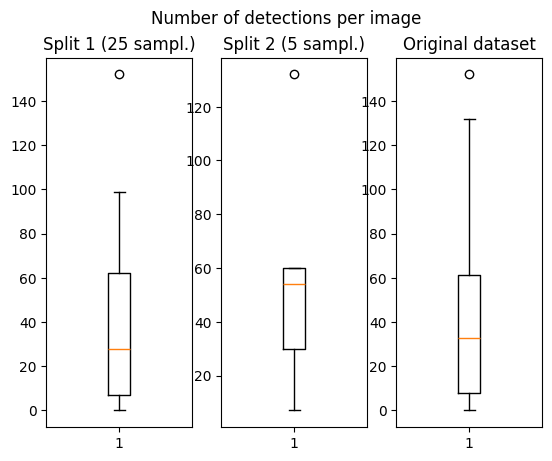

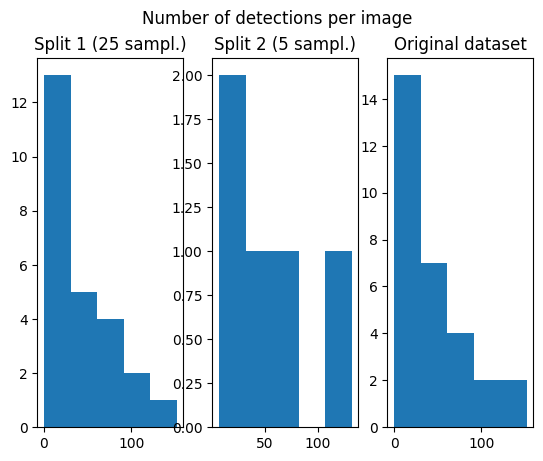

In [19]:
image_paths_3 = get_images_paths(dataset_3)
target_paths_3 = get_annotations_paths(image_paths_3, dataset_3)
nr_detections_3 = []
for target_path in target_paths_3:
    target = pd.read_csv(target_path)
    nr_detections_3.append(len(target))
bins_3 = bin(nr_detections_3, 5)

x_1, x_2, y_1, y_2 = train_test_split(image_paths_3, nr_detections_3, train_size=25, stratify=bins_3)

print(len(x_1), len(x_2))
images_paths_train.extend(x_1)
images_paths_val.extend(x_2)

figure, ax = plt.subplots(1, 3)
ax[0].boxplot(y_1)
ax[0].set_title("Split 1 (25 sampl.)")
ax[1].boxplot(y_2)
ax[1].set_title("Split 2 (5 sampl.)")
ax[2].boxplot(nr_detections_3)
ax[2].set_title("Original dataset")
figure.suptitle("Number of detections per image")
plt.show()

figure, ax = plt.subplots(1, 3)
ax[0].hist(y_1, bins=5)
ax[0].set_title("Split 1 (25 sampl.)")
ax[1].hist(y_2, bins=5)
ax[1].set_title("Split 2 (5 sampl.)")
ax[2].hist(nr_detections_3, bins=5)
ax[2].set_title("Original dataset")
figure.suptitle("Number of detections per image")
plt.show()






25 5


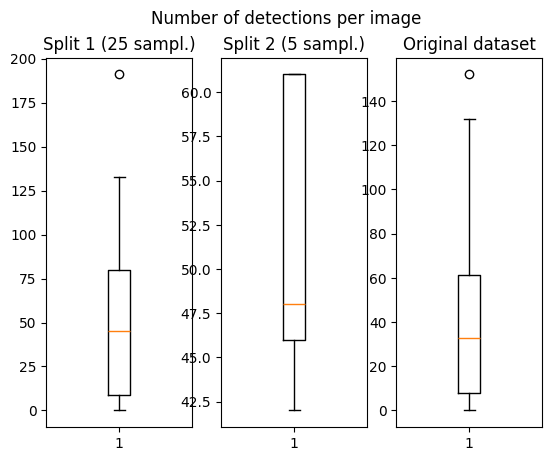

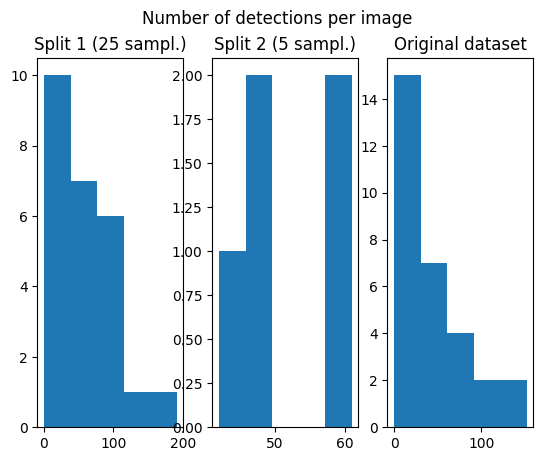

In [20]:
image_paths_4 = get_images_paths(dataset_4)
target_paths_4 = get_annotations_paths(image_paths_4, dataset_4)
nr_detections_4 = []
for target_path in target_paths_4:
    target = pd.read_csv(target_path)
    nr_detections_4.append(len(target))
bins_4 = bin(nr_detections_4, 5)

x_1, x_2, y_1, y_2 = train_test_split(image_paths_4, nr_detections_4, train_size=25, stratify=bins_4)

print(len(x_1), len(x_2))
images_paths_train.extend(x_1)
images_paths_val.extend(x_2)

figure, ax = plt.subplots(1, 3)
ax[0].boxplot(y_1)
ax[0].set_title("Split 1 (25 sampl.)")
ax[1].boxplot(y_2)
ax[1].set_title("Split 2 (5 sampl.)")
ax[2].boxplot(nr_detections_3)
ax[2].set_title("Original dataset")
figure.suptitle("Number of detections per image")
plt.show()

figure, ax = plt.subplots(1, 3)
ax[0].hist(y_1, bins=5)
ax[0].set_title("Split 1 (25 sampl.)")
ax[1].hist(y_2, bins=5)
ax[1].set_title("Split 2 (5 sampl.)")
ax[2].hist(nr_detections_3, bins=5)
ax[2].set_title("Original dataset")
figure.suptitle("Number of detections per image")
plt.show()


Check for data leak between splits

In [21]:
print(f"Number of images in train set: {len(images_paths_train)}")
print(f"Number of images in val set: {len(images_paths_val)}")  
print(f"Number of images in test set: {len(images_paths_test)}")

# check training set
for train_path in images_paths_train:
    assert os.path.exists(train_path), f"Image {train_path} does not exist"
    assert train_path not in images_paths_val, f"Image {train_path} is in both train and val sets"
    assert train_path not in images_paths_test, f"Image {train_path} is in both train and test sets"
# check validation set
for val_path in images_paths_val:
    assert os.path.exists(val_path), f"Image {val_path} does not exist"
    assert val_path not in images_paths_train, f"Image {val_path} is in both train and val sets"
    assert val_path not in images_paths_test, f"Image {val_path} is in both val and test sets"
# check test set
for test_path in images_paths_test:
    assert os.path.exists(test_path), f"Image {test_path} does not exist"
    assert test_path not in images_paths_train, f"Image {test_path} is in both train and test sets"
    assert test_path not in images_paths_val, f"Image {test_path} is in both val and test sets"
# check that the number of images is correct



Number of images in train set: 70
Number of images in val set: 15
Number of images in test set: 15


## Creta Train, Val e Test datasets

In [22]:
train_dataset = "../dataset/train"
val_dataset = "../dataset/val"
test_dataset = "../dataset/test"

create_dataset(images_paths_train, train_dataset)
create_dataset(images_paths_val, val_dataset)
create_dataset(images_paths_test, test_dataset)

In [23]:
df = pd.DataFrame(data=[["x", "A-01", 1], ["x", "C-01", 1], ["x", "B-02", 1], ["x", "A-02", 1], ["x", "B-01", 1], ["x", "C-02", 1]], columns=[0, 1, 2])
display(df)
df.sort_values(by=1, axis=0, inplace=True)
display(df)

,0,1,2
0,x,A-01,1
1,x,C-01,1
2,x,B-02,1
3,x,A-02,1
4,x,B-01,1
5,x,C-02,1


,0,1,2
0,x,A-01,1
3,x,A-02,1
4,x,B-01,1
2,x,B-02,1
1,x,C-01,1
5,x,C-02,1
